<a href="https://colab.research.google.com/github/mdrapha/Deepfake-Detection/blob/main/deepfakes_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Algoritmo Para Detecção de Imagens de Faces DeepFakes**
## **Universidade Federal de São Paulo - UNIFESP**

### Disciplina: Inteligência Artificial
### Professor: Fábio Faria
### Integrantes:
###  -  Marco Antonio Coral dos Santos
###  -  Raphael Damasceno Rocha de Moraes

# **1. Introdução**

In [3]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sb
import torch
from torchvision import models
from torch import nn
from torch import optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models.vision_transformer import vit_b_16, ViT_B_16_Weights
from torchvision.utils import make_grid
from torch.autograd import Variable
import torch.optim.lr_scheduler as lr_scheduler
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, precision_recall_fscore_support
import shutil
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings("ignore")

code_dir = "/kaggle/working/code"
model_dir = "/kaggle/working/model"
output_dir = "/kaggle/working/output"

if not os.path.exists(code_dir):
    os.mkdir(code_dir)

if not os.path.exists(model_dir):
    os.mkdir(model_dir)

if not os.path.exists(output_dir):
    os.mkdir(output_dir)

shutil.copyfile(src="/kaggle/input/modelos/convnext.py",
                dst="/kaggle/working/code/convnext.py")
shutil.copyfile(src="/kaggle/input/modelos/convnext_tiny_1k_224_ema.pth",
                dst="/kaggle/working/model/convnext_tiny_1k_224_ema.pth")
shutil.copyfile(src="/kaggle/input/modelos/vit_b_16-c867db91.pth",
                dst="/kaggle/working/model/vit_b_16-c867db91.pth")

os.chdir("/kaggle/working/code")


from convnext import ConvNeXt


# **2. Banco de Dados**

In [ ]:
local_arquivos='/kaggle/input/140k-real-and-fake-faces'
treino = pd.read_csv(local_arquivos + "/train.csv")
teste = pd.read_csv(local_arquivos + "/test.csv")
print(teste.shape)
print(treino.shape)

(20000, 6)
(100000, 6)


##**2.1. Imagens Reais e Falsas**




In [82]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor()
])

local='/content/'
subsample = ImageFolder(root= local + 'subsample/', transform=transform )
indices = [random.randint(0, len(subsample)) for i in range(16)]

classes=subsample.classes
classes_to_id= subsample.class_to_idx
id_to_class= dict(zip(classes_to_id.values(), classes_to_id.keys()))

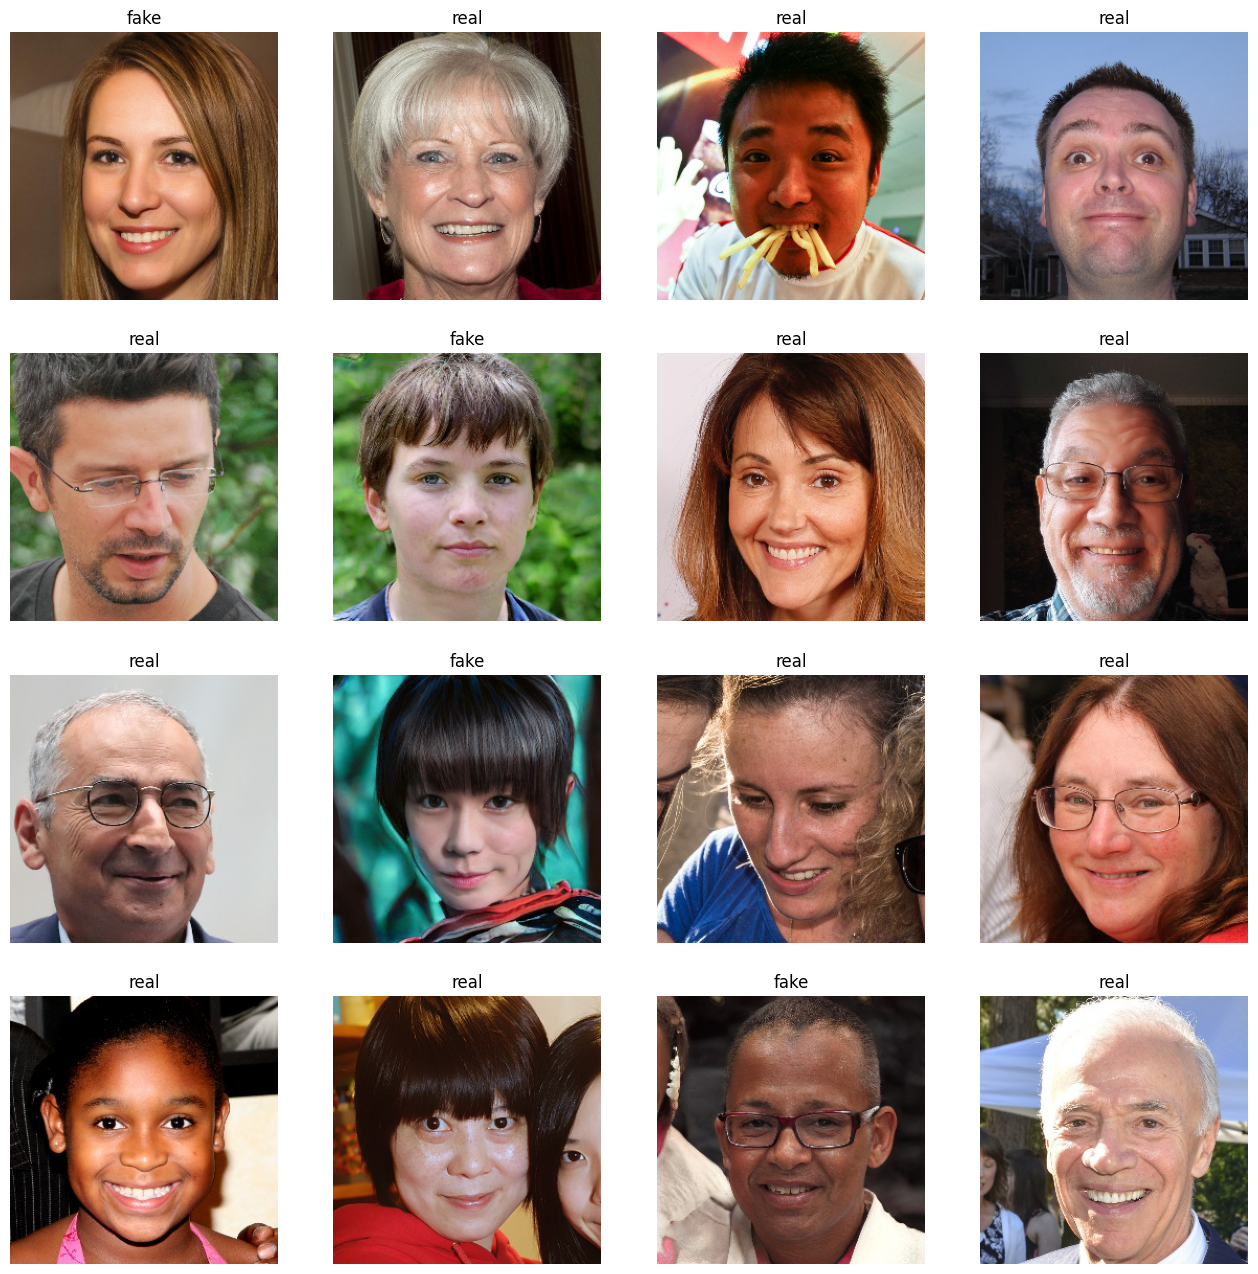

In [83]:
figure = plt.figure(figsize=(16, 16))
for i in range(16):
    index = indices[i]
    img = subsample[index][0].permute(1, 2, 0)
    label = id_to_class[subsample[index][1]]
    figure.add_subplot(4, 4, i + 1)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img)

## **2.1. Arquiteturas de Rede**

Definição das arquiteturas de modelos pré treinados a serem utilizadas para o experimento.

In [ ]:
#Instanciando o modelo ConvNeXt
def ConvNeXt_model():
    model_conv=ConvNeXt()
    state_dict = torch.load('/kaggle/working/model/convnext_tiny_1k_224_ema.pth')
    model_conv.load_state_dict(state_dict["model"])

    return model_conv


In [ ]:
#Instanciando o modelo ViT
def ViT_model():
    model_vit=vit_b_16(pretrained=True)
    return model_vit


Definição do dispositivo a ser utilizado para o processamento

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Definição do critério de Loss a ser utilizado, no modelo optamos pela utilização da CrossEntropy.

In [ ]:
criterion = nn.CrossEntropyLoss()

Definição de listas de suporte para armazenamento de resultados, além da definição de um DataFrame da biblioteca panda para armazenar os resultados e facilitar na hora do tratamento dos mesmos.

In [ ]:
train_acc, teste_acc, train_loss, teste_loss = [], [], [], []
train_precision, teste_precision, train_recall, teste_recall = [], [], [], []
train_f1, teste_f1 = [], []
df = pd.DataFrame(columns=['Modelo','Experimento','Epoch', 'Train ACC', 'Train Loss', 'Train F1', 'Test ACC', 'Test Loss', 'Test F1'])

# **3. Metodologia**

## **3.1. Aumento de Dados**

### **3.1.1. Processamento das Imagens**

Função para transformação básica no dataset para aplicações nos cenários sem aumento de dados, de forma a apenas realizar redimensionamento, corte centralizados, normalização das cores e passagem dos objetos para Tensor.

As funções abaixo se diferem apenas nos conjuntos onde se aplicam as tranformações, enquanto a primeira aplica nos conjuntos de treino e teste, a segunda aplica somente no conjunto de teste, o que será utilizado nos cenários onde o aumentod e dados será aplicado no conjunto de treino de forma separada.

In [ ]:
def full_data_transform(model_type, data_fraction, batch_size):
    # Transformações de dados
    if model_type== 'convnext':
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    elif model_type == 'vit':
        transform = ViT_B_16_Weights.IMAGENET1K_V1.transforms()


    local_arquivos='/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake'
    full_train_dataset = ImageFolder(local_arquivos + "/train", transform=transform)
    full_test_dataset = ImageFolder(local_arquivos + "/test", transform=transform)

    # Determinar o número de objetos a serem selecionados
    num_train_data = int(len(full_train_dataset) * data_fraction)
    num_test_data = int(len(full_test_dataset) * data_fraction)



    # Selecionar aleatoriamente os objetos para os conjuntos de dados
    train_indices = random.sample(range(len(full_train_dataset)), num_train_data)
    test_indices = random.sample(range(len(full_test_dataset)), num_test_data)

    # Criar os datasets com a seleção aleatória de objetos
    train_dataset = torch.utils.data.Subset(full_train_dataset, train_indices)
    test_dataset = torch.utils.data.Subset(full_test_dataset, test_indices)

    # Criação dos dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=int(batch_size/2), shuffle=False)


    return train_dataloader, test_dataloader

def ft_data_transform(model_type, data_fraction, batch_size):
    # Transformações de dados
    if model_type== 'convnext':
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])


    elif model_type == 'vit':
        transform = ViT_B_16_Weights.IMAGENET1K_V1.transforms()

    local_arquivos='/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake'
    full_test_dataset = ImageFolder(local_arquivos + "/test", transform=transform)

    # Determinar o número de objetos a serem selecionados
    num_test_data = int(len(full_test_dataset) * data_fraction)


    # Selecionar aleatoriamente os objetos para os conjuntos de dados
    test_indices = random.sample(range(len(full_test_dataset)), num_test_data)

    # Criar os datasets com a seleção aleatória de objetos
    test_dataset = torch.utils.data.Subset(full_test_dataset, test_indices)

    # Criação dos dataloaders
    test_dataloader = DataLoader(test_dataset, batch_size=int(batch_size/2), shuffle=False)

    return test_dataloader

### **3.1.2. AutoAugment**

Função para aplicação do aumento de dados AutoAugment, de modo a aplicar transformações necessárias pela rede de forma prévia, como redimensionamento e outras características específicas da arquitetura de cada rede utilizada.

In [ ]:
def AutoAugment_transform(model_type, train_indices, batch_size):
    if model_type== 'convnext':
        augmentation_transforms = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.AutoAugment(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    elif model_type == 'vit':
        augmentation_transforms = transforms.Compose([
            transforms.Resize(224, interpolation=Image.BILINEAR),
            transforms.CenterCrop(224),
            transforms.AutoAugment(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    local_arquivos='/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake'
    augmented_train_dataset = ImageFolder(local_arquivos + "/train", transform=augmentation_transforms)
    augmented_train_dataset = torch.utils.data.Subset(augmented_train_dataset, train_indices)
    augmented_train_dataloader = DataLoader(augmented_train_dataset, batch_size=batch_size, shuffle=True)

    return augmented_train_dataloader


### **3.1.3. RandAugment**

Função para aplicação do aumento de dados RandAugment, de modo a aplicar transformações necessárias pela rede de forma prévia, como redimensionamento e outras características específicas da arquitetura de cada rede utilizada.

In [ ]:
def RandAugment_transform(model_type, train_indices, batch_size):
    if model_type== 'convnext':
        augmentation_transforms = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.RandAugment(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    elif model_type == 'vit':
        augmentation_transforms = transforms.Compose([
            transforms.Resize(224, interpolation=Image.BILINEAR),
            transforms.CenterCrop(224),
            transforms.RandAugment(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    local_arquivos='/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake'
    augmented_train_dataset = ImageFolder(local_arquivos + "/train", transform=augmentation_transforms)
    augmented_train_dataset = torch.utils.data.Subset(augmented_train_dataset, train_indices)
    augmented_train_dataloader = DataLoader(augmented_train_dataset, batch_size=batch_size, shuffle=True)

    return augmented_train_dataloader


### **3.1.4. Auto+Rand Augment**

Função para aplicação conjunta do aumento de dados AutoAugment e RandAugment

In [ ]:
def Auto_RandAugment_transform(model_type, train_indices, batch_size):
    if model_type== 'convnext':
        augmentation_transforms = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.AutoAugment(),
            transforms.RandAugment(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    elif model_type == 'vit':
        augmentation_transforms = transforms.Compose([
            transforms.Resize(224, interpolation=Image.BILINEAR),
            transforms.CenterCrop(224),
            transforms.AutoAugment(),
            transforms.RandAugment(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    local_arquivos='/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake'
    augmented_train_dataset = ImageFolder(local_arquivos + "/train", transform=augmentation_transforms)
    augmented_train_dataset = torch.utils.data.Subset(augmented_train_dataset, train_indices)
    augmented_train_dataloader = DataLoader(augmented_train_dataset, batch_size=batch_size, shuffle=True)

    return augmented_train_dataloader

## **3.2. Treinamento e Teste**

Função para treinar os modelos de modo a realizar ou não ajuste nos parâmetros da rede, conforme o cenário a ser testado.
Além de salvar os modelos de redes treinadas a cada experimento diferente realizado.

In [ ]:
 # Função de treino genérica
def train(model, dataloader, criterion, optimizer, scheduler, device, ft, epoch, exp, model_type):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    y_true,y_pred=[], []

    loop = tqdm(enumerate(dataloader), total=len(dataloader))
    for batch_idx, (images, labels) in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        if ft==False:
            for param in model.parameters():
                param.requires_grad=False

            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.step()

            for param in model.parameters():
                param.requires_grad=True
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        running_loss += loss.item()
        predicted = outputs.argmax(dim = 1)

        y_true.extend(labels.cpu().tolist())
        y_pred.extend(predicted.cpu().tolist())

        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        loop.set_description(f"[Epoch {(epoch+1)}]")
        loop.set_postfix(loss=loss.item())

    if scheduler:
        scheduler.step()

    train_loss = running_loss / len(dataloader.dataset)
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro',zero_division=0)

    print(f"Train Loss: {train_loss:.6f} | Train Accuracy: {(accuracy * 100):.2f}% | Train F1-Score: {f1:.6f}")

    model_name= f'model_{model_type}_params_exp_{exp}.pth'
    torch.save(model.state_dict(), os.path.join('/kaggle/working/model', model_name))

    return train_loss, accuracy, f1

Função de teste para validar o modelo após treinamento.

In [ ]:
# Função de teste genérica
def test(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    y_pred, y_true= [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)


            running_loss += loss.item()
            predicted = outputs.argmax(dim = 1)

            y_true.extend(labels.cpu().tolist())
            y_pred.extend(predicted.cpu().tolist())

            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss = running_loss / len(list(dataloader.dataset))
    test_accuracy = accuracy = accuracy_score(y_true, y_pred)
    precision, recall, test_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro',zero_division=0)

    print(f"Test Loss: {test_loss:.6f} | Test Accuracy: {(test_accuracy * 100):.2f}% | Test F1-Score: {test_f1:.6f}")
    return test_loss, test_accuracy, test_f1


Função para realizar o treinamento e teste em cada experimento de forma sequencial.

In [ ]:
# Função genérica para treinar, testar
def train_model(model_type, exp,model, train_dataloader, test_dataloader, criterion, optimizer, scheduler, device, num_epochs, ft, num):
    model=model.to(device)
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        print('----------------------------------------------------------------------------')
        train_loss, train_accuracy, train_f1 = train(model, train_dataloader, criterion, optimizer, scheduler, device, ft, epoch, exp, model_type)
        test_loss, test_accuracy,test_f1 = test(model, test_dataloader, criterion, device)
        val=str(num)+str(epoch+1)
        df.loc[val]=[model_type, exp, epoch+1, train_accuracy, train_loss, train_f1, test_accuracy, test_loss, test_f1]
        df.to_csv('metricas.csv', index = False)
        print('\n')



    return train_loss, train_accuracy, train_f1, test_loss, test_accuracy,test_f1


## **3.3. Protocolo Experimental**

**Aplicando protocolo experimental para os cenários resultantes das permutações dos Aumentos de Dados (AutoAugment e RandAugment) e Fine-Tuning, para cada modelo testado:**

**-Modelo: ConvNeXt pré treinado**
1. ConvNeXt Sem Fine-Tuning
2. ConvNeXt Com Fine-Tuning
3. ConvNeXt Sem Fine Tuning e com AutoAugment
4. ConvNeXt Com Fine Tuning e com AutoAugment
5. ConvNeXt Sem Fine Tuning e com RandAugment
6. ConvNeXt Com Fine Tuning e com RandAugment
7. ConvNeXt Sem Fine Tuning e com AutoAugment e RandAugment
8. ConvNeXt Com Fine Tuning e com AutoAugment e RandAugment

**-Modelo: ViT pré treinado**
9. ViT Sem Fine-Tuning
10. ViT Com Fine-Tuning
11. ViT Sem Fine Tuning e com AutoAugment
12. ViT Com Fine Tuning e com AutoAugment
13. ViT Sem Fine Tuning e com RandAugment
14. ViT Com Fine Tuning e com RandAugment
15. ViT Sem Fine Tuning e com AutoAugment e RandAugment
16. ViT Com Fine Tuning e com AutoAugment e RandAugment

In [ ]:
def run_scenario(model_type, scenario, data_fraction, num_epochs=10, batch_size=32, learning_rate=0.001):
    num_classes = 2
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    num_train_data = int((100000) * data_fraction)
    num_test_data = int((20000) * data_fraction)

    train_indices = random.sample(range(100000), num_train_data)
    test_indices = random.sample(range(20000), num_test_data)

    print(f'Número de objetos de treino: {num_train_data}')
    print(f'Número de objetos de teste: {num_test_data}')
    print("============================================================================")

    if scenario == 1:

        train_dataloader, test_dataloader= full_data_transform(model_type, data_fraction, batch_size)

        # Selecionar o modelo
        if model_type == 'convnext':
            model = ConvNeXt_model()
            model.head = nn.Linear(model.head.in_features, num_classes)  # Substituir num_classes pelo número correto de classes
            num=1

        elif model_type == 'vit':
            model = ViT_model()
            model.heads=nn.Linear(768,2)
            num=9
        else:
            raise ValueError("O parâmetro 'model_type' deve ser 'convnext' ou 'vit'.")

        model = model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

        if model_type == 'convnext':
            print("Experimento 1 - ConvNeXt (Sem Fine-Tuning)")
        elif model_type == 'vit':
            print("Experimento 1 - ViT (Sem Fine-Tuning)")

        train_loss, train_accuracy, train_f1, test_loss, test_accuracy,test_f1 = train_model(model_type,1, model, train_dataloader, test_dataloader,
                                                                                    criterion, optimizer, scheduler, device, 1, False, num)
    elif scenario == 2:

        train_dataloader, test_dataloader= full_data_transform(model_type, data_fraction, batch_size)

        # Selecionar o modelo
        if model_type == 'convnext':
            model = ConvNeXt_model()
            model.head = nn.Linear(model.head.in_features, num_classes)  # Substituir num_classes pelo número correto de classes
            num=2

        elif model_type == 'vit':
            model = ViT_model()
            model.heads=nn.Linear(768,2)
            num=10
        else:
            raise ValueError("O parâmetro 'model_type' deve ser 'convnext' ou 'vit'.")

        model = model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

        if model_type == 'convnext':
             print("Experimento 2 - ConvNeXt (Com Fine-Tuning)")
        elif model_type == 'vit':
            print("Experimento 2 - ViT (Com Fine-Tuning)")

        train_loss, train_accuracy, train_f1, test_loss, test_accuracy,test_f1 = train_model(model_type,2, model, train_dataloader, test_dataloader,
                                                                                    criterion, optimizer, scheduler, device, num_epochs, True, num)
    elif scenario == 3:

        augmented_train_dataloader = AutoAugment_transform(model_type, train_indices, batch_size)
        test_dataloader=ft_data_transform(model_type, data_fraction, batch_size)

        # Selecionar o modelo
        if model_type == 'convnext':
            model = ConvNeXt_model()
            model.head = nn.Linear(model.head.in_features, num_classes)  # Substituir num_classes pelo número correto de classes
            num=3

        elif model_type == 'vit':
            model = ViT_model()
            model.heads=nn.Linear(768,2)
            num=11
        else:
            raise ValueError("O parâmetro 'model_type' deve ser 'convnext' ou 'vit'.")

        model = model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

        if model_type == 'convnext':
            print("Experimento 3 - ConvNeXt (Sem Fine-Tuning e com AutoAugment)")
        elif model_type == 'vit':
            print("Experimento 3 - ViT (Sem Fine-Tuning e com AutoAugment)")


        train_loss, train_accuracy, train_f1, test_loss, test_accuracy,test_f1 = train_model(model_type,3, model, augmented_train_dataloader, test_dataloader,
                                                                                   criterion, optimizer, scheduler, device, 1, False, num)
        # Selecionar o modelo
        if model_type == 'convnext':
            model = ConvNeXt_model()
            model.head = nn.Linear(model.head.in_features, num_classes)  # Substituir num_classes pelo número correto de classes
            num=4

        elif model_type == 'vit':
            model = ViT_model()
            model.heads=nn.Linear(768,2)
            num=12
        else:
            raise ValueError("O parâmetro 'model_type' deve ser 'convnext' ou 'vit'.")

        model = model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

        if model_type == 'convnext':
            print("Experimento 4 - ConvNeXt (Com Fine-Tuning e com AutoAugment)")
        elif model_type == 'vit':
            print("Experimento 4 - ViT (Com Fine-Tuning e com AutoAugment)")

        train_loss, train_accuracy, train_f1, test_loss, test_accuracy,test_f1 = train_model(model_type,4, model, augmented_train_dataloader, test_dataloader,
                                                                                   criterion, optimizer, scheduler, device, num_epochs, True, num)

    elif scenario == 4:
        augmented_train_dataloader = RandAugment_transform(model_type, train_indices, batch_size)
        test_dataloader=ft_data_transform(model_type, data_fraction, batch_size)

        # Selecionar o modelo
        if model_type == 'convnext':
            model = ConvNeXt_model()
            model.head = nn.Linear(model.head.in_features, num_classes)  # Substituir num_classes pelo número correto de classes
            num=5

        elif model_type == 'vit':
            model = ViT_model()
            model.heads=nn.Linear(768,2)
            num=13
        else:
            raise ValueError("O parâmetro 'model_type' deve ser 'convnext' ou 'vit'.")

        model = model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

        if model_type == 'convnext':
            print("Experimento 5 - ConvNeXt (Sem Fine-Tuning e com RandAugment)")
        elif model_type == 'vit':
            print("Experimento 5 - ViT (Sem Fine-Tuning e com RandAugment)")

        train_loss, train_accuracy, train_f1, test_loss, test_accuracy,test_f1 = train_model(model_type,5, model, augmented_train_dataloader, test_dataloader,
                                                                                   criterion, optimizer, scheduler, device, 1, False, num)

        # Selecionar o modelo
        if model_type == 'convnext':
            model = ConvNeXt_model()
            model.head = nn.Linear(model.head.in_features, num_classes)  # Substituir num_classes pelo número correto de classes
            num=6

        elif model_type == 'vit':
            model = ViT_model()
            model.heads=nn.Linear(768,2)
            num=14
        else:
            raise ValueError("O parâmetro 'model_type' deve ser 'convnext' ou 'vit'.")

        model = model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

        if model_type == 'convnext':
            print("Experimento 6 - ConvNeXt (Com Fine-Tuning e com RandAugment)")
        elif model_type == 'vit':
            print("Experimento 6 - ViT (Com Fine-Tuning e com RandAugment)")


        train_loss, train_accuracy, train_f1, test_loss, test_accuracy,test_f1 = train_model(model_type,6, model, augmented_train_dataloader, test_dataloader,
                                                                                   criterion, optimizer, scheduler, device, num_epochs, True, num)

    elif scenario == 5:
        augmented_train_dataloader = Auto_RandAugment_transform(model_type, train_indices, batch_size)
        test_dataloader=ft_data_transform(model_type, data_fraction, batch_size)

        # Selecionar o modelo
        if model_type == 'convnext':
            model = ConvNeXt_model()
            model.head = nn.Linear(model.head.in_features, num_classes)  # Substituir num_classes pelo número correto de classes
            num=7

        elif model_type == 'vit':
            model = ViT_model()
            model.heads=nn.Linear(768,2)
            num=15
        else:
            raise ValueError("O parâmetro 'model_type' deve ser 'convnext' ou 'vit'.")

        model = model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

        if model_type == 'convnext':
            print("Experimento 7 - ConvNeXt (Sem Fine-Tuning e com RandAugment e AutoAugment)")
        elif model_type == 'vit':
            print("Experimento 7 - ViT (Sem Fine-Tuning e com RandAugment e AutoAugment)")

        train_loss, train_accuracy, train_f1, test_loss, test_accuracy,test_f1 = train_model(model_type,7, model, augmented_train_dataloader, test_dataloader,
                                                                                   criterion, optimizer, scheduler, device, 1, False, num)

        # Selecionar o modelo
        if model_type == 'convnext':
            model = ConvNeXt_model()
            model.head = nn.Linear(model.head.in_features, num_classes)  # Substituir num_classes pelo número correto de classes
            num=8

        elif model_type == 'vit':
            model = ViT_model()
            model.heads=nn.Linear(768,2)
            num=16
        else:
            raise ValueError("O parâmetro 'model_type' deve ser 'convnext' ou 'vit'.")

        model = model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

        if model_type == 'convnext':
            print("Experimento 8 - ConvNeXt (Com Fine-Tuning e com RandAugment e AutoAugment)")
        elif model_type == 'vit':
            print("Experimento 8 - ViT (Com Fine-Tuning e com RandAugment e AutoAugment)")

        train_loss, train_accuracy, train_f1, test_loss, test_accuracy,test_f1 = train_model(model_type,8, model, augmented_train_dataloader, test_dataloader,
                                                                                   criterion, optimizer, scheduler, device, num_epochs, True, num)
    else:
        raise ValueError("O parâmetro 'scenario' deve ser um número entre 1 e 5.")



## **3.4. Avaliação de Desempenho**

Execução dos experimentos e coleta dos resultados para analise posterior no DataFrame.

In [ ]:

run_scenario('convnext',1,0.1, num_epochs=10, batch_size=16, learning_rate=0.0001)


Número de objetos de treino: 10000
Número de objetos de teste: 2000
Experimento 1 - ConvNeXt (Sem Fine-Tuning)
----------------------------------------------------------------------------


[Epoch 1]: 100%|██████████| 625/625 [01:42<00:00,  6.07it/s, loss=0.664]


Train Loss: 0.043721 | Train Accuracy: 50.09% | Train F1-Score: 0.389926
Test Loss: 0.087877 | Test Accuracy: 49.20% | Test F1-Score: 0.392914




In [ ]:
run_scenario('convnext',2,0.1, num_epochs=10, batch_size=16, learning_rate=0.0001)

Número de objetos de treino: 10000
Número de objetos de teste: 2000
Experimento 2 - ConvNeXt (Com Fine-Tuning)
----------------------------------------------------------------------------


[Epoch 1]: 100%|██████████| 625/625 [03:01<00:00,  3.45it/s, loss=0.00156]


Train Loss: 0.006944 | Train Accuracy: 95.14% | Train F1-Score: 0.951400
Test Loss: 0.001048 | Test Accuracy: 99.75% | Test F1-Score: 0.997497


----------------------------------------------------------------------------


[Epoch 2]: 100%|██████████| 625/625 [02:29<00:00,  4.19it/s, loss=0.000112]


Train Loss: 0.000435 | Train Accuracy: 99.76% | Train F1-Score: 0.997600
Test Loss: 0.000662 | Test Accuracy: 99.85% | Test F1-Score: 0.998498


----------------------------------------------------------------------------


[Epoch 3]: 100%|██████████| 625/625 [02:30<00:00,  4.16it/s, loss=0.000107]


Train Loss: 0.000015 | Train Accuracy: 100.00% | Train F1-Score: 1.000000
Test Loss: 0.000624 | Test Accuracy: 99.85% | Test F1-Score: 0.998498


----------------------------------------------------------------------------


[Epoch 4]: 100%|██████████| 625/625 [02:30<00:00,  4.16it/s, loss=6.53e-5]


Train Loss: 0.000009 | Train Accuracy: 100.00% | Train F1-Score: 1.000000
Test Loss: 0.000643 | Test Accuracy: 99.85% | Test F1-Score: 0.998498


----------------------------------------------------------------------------


[Epoch 5]: 100%|██████████| 625/625 [02:29<00:00,  4.18it/s, loss=7.76e-5]


Train Loss: 0.000008 | Train Accuracy: 100.00% | Train F1-Score: 1.000000
Test Loss: 0.000641 | Test Accuracy: 99.85% | Test F1-Score: 0.998498


----------------------------------------------------------------------------


[Epoch 6]: 100%|██████████| 625/625 [02:29<00:00,  4.17it/s, loss=0.000231]


Train Loss: 0.000008 | Train Accuracy: 100.00% | Train F1-Score: 1.000000
Test Loss: 0.000642 | Test Accuracy: 99.85% | Test F1-Score: 0.998498


----------------------------------------------------------------------------


[Epoch 7]: 100%|██████████| 625/625 [02:29<00:00,  4.17it/s, loss=0.000124]


Train Loss: 0.000008 | Train Accuracy: 100.00% | Train F1-Score: 1.000000
Test Loss: 0.000642 | Test Accuracy: 99.85% | Test F1-Score: 0.998498


----------------------------------------------------------------------------


[Epoch 8]: 100%|██████████| 625/625 [02:29<00:00,  4.18it/s, loss=0.000101]


Train Loss: 0.000008 | Train Accuracy: 100.00% | Train F1-Score: 1.000000
Test Loss: 0.000642 | Test Accuracy: 99.85% | Test F1-Score: 0.998498


----------------------------------------------------------------------------


[Epoch 9]: 100%|██████████| 625/625 [02:29<00:00,  4.17it/s, loss=8.65e-5]


Train Loss: 0.000008 | Train Accuracy: 100.00% | Train F1-Score: 1.000000
Test Loss: 0.000642 | Test Accuracy: 99.85% | Test F1-Score: 0.998498


----------------------------------------------------------------------------


[Epoch 10]: 100%|██████████| 625/625 [02:29<00:00,  4.17it/s, loss=8.3e-5]


Train Loss: 0.000008 | Train Accuracy: 100.00% | Train F1-Score: 1.000000
Test Loss: 0.000642 | Test Accuracy: 99.85% | Test F1-Score: 0.998498




In [ ]:
run_scenario('convnext',3,0.1, num_epochs=10, batch_size=16, learning_rate=0.0001)

Número de objetos de treino: 10000
Número de objetos de teste: 2000
Experimento 3 - ConvNeXt (Sem Fine-Tuning e com AutoAugment)
----------------------------------------------------------------------------


[Epoch 1]: 100%|██████████| 625/625 [01:44<00:00,  5.98it/s, loss=0.698]


Train Loss: 0.043236 | Train Accuracy: 51.92% | Train F1-Score: 0.518713
Test Loss: 0.086623 | Test Accuracy: 51.55% | Test F1-Score: 0.515490


Experimento 4 - ConvNeXt (Com Fine-Tuning e com AutoAugment)
----------------------------------------------------------------------------


[Epoch 1]: 100%|██████████| 625/625 [02:43<00:00,  3.83it/s, loss=0.0839]


Train Loss: 0.012421 | Train Accuracy: 91.15% | Train F1-Score: 0.911499
Test Loss: 0.004486 | Test Accuracy: 98.80% | Test F1-Score: 0.987980


----------------------------------------------------------------------------


[Epoch 2]: 100%|██████████| 625/625 [02:43<00:00,  3.83it/s, loss=0.0482]


Train Loss: 0.003087 | Train Accuracy: 98.00% | Train F1-Score: 0.980000
Test Loss: 0.000736 | Test Accuracy: 99.85% | Test F1-Score: 0.998499


----------------------------------------------------------------------------


[Epoch 3]: 100%|██████████| 625/625 [02:43<00:00,  3.83it/s, loss=0.00857]


Train Loss: 0.001023 | Train Accuracy: 99.45% | Train F1-Score: 0.994500
Test Loss: 0.000586 | Test Accuracy: 99.85% | Test F1-Score: 0.998499


----------------------------------------------------------------------------


[Epoch 4]: 100%|██████████| 625/625 [02:43<00:00,  3.83it/s, loss=0.00927]


Train Loss: 0.000703 | Train Accuracy: 99.59% | Train F1-Score: 0.995900
Test Loss: 0.000561 | Test Accuracy: 99.85% | Test F1-Score: 0.998499


----------------------------------------------------------------------------


[Epoch 5]: 100%|██████████| 625/625 [02:42<00:00,  3.83it/s, loss=0.00471]


Train Loss: 0.000620 | Train Accuracy: 99.67% | Train F1-Score: 0.996700
Test Loss: 0.000539 | Test Accuracy: 99.85% | Test F1-Score: 0.998499


----------------------------------------------------------------------------


[Epoch 6]: 100%|██████████| 625/625 [02:43<00:00,  3.82it/s, loss=0.000775]


Train Loss: 0.000664 | Train Accuracy: 99.66% | Train F1-Score: 0.996600
Test Loss: 0.000578 | Test Accuracy: 99.80% | Test F1-Score: 0.997998


----------------------------------------------------------------------------


[Epoch 7]: 100%|██████████| 625/625 [02:43<00:00,  3.83it/s, loss=0.00129]


Train Loss: 0.000614 | Train Accuracy: 99.65% | Train F1-Score: 0.996500
Test Loss: 0.000573 | Test Accuracy: 99.80% | Test F1-Score: 0.997998


----------------------------------------------------------------------------


[Epoch 8]: 100%|██████████| 625/625 [02:43<00:00,  3.82it/s, loss=0.0164]


Train Loss: 0.000536 | Train Accuracy: 99.71% | Train F1-Score: 0.997100
Test Loss: 0.000564 | Test Accuracy: 99.85% | Test F1-Score: 0.998499


----------------------------------------------------------------------------


[Epoch 9]: 100%|██████████| 625/625 [02:43<00:00,  3.83it/s, loss=0.00108]


Train Loss: 0.000443 | Train Accuracy: 99.77% | Train F1-Score: 0.997700
Test Loss: 0.000565 | Test Accuracy: 99.85% | Test F1-Score: 0.998499


----------------------------------------------------------------------------


[Epoch 10]: 100%|██████████| 625/625 [02:43<00:00,  3.82it/s, loss=0.000536]


Train Loss: 0.000525 | Train Accuracy: 99.75% | Train F1-Score: 0.997500
Test Loss: 0.000564 | Test Accuracy: 99.85% | Test F1-Score: 0.998499




In [ ]:
run_scenario('convnext',4,0.1, num_epochs=10, batch_size=16, learning_rate=0.0001)

Número de objetos de treino: 10000
Número de objetos de teste: 2000
Experimento 5 - ConvNeXt (Sem Fine-Tuning e com RandAugment)
----------------------------------------------------------------------------


[Epoch 1]: 100%|██████████| 625/625 [01:48<00:00,  5.77it/s, loss=0.713]


Train Loss: 0.043883 | Train Accuracy: 48.62% | Train F1-Score: 0.445928
Test Loss: 0.087562 | Test Accuracy: 49.55% | Test F1-Score: 0.452416


Experimento 6 - ConvNeXt (Com Fine-Tuning e com RandAugment)
----------------------------------------------------------------------------


[Epoch 1]: 100%|██████████| 625/625 [02:46<00:00,  3.74it/s, loss=0.0348]


Train Loss: 0.013118 | Train Accuracy: 90.21% | Train F1-Score: 0.902092
Test Loss: 0.001721 | Test Accuracy: 99.50% | Test F1-Score: 0.994998


----------------------------------------------------------------------------


[Epoch 2]: 100%|██████████| 625/625 [02:46<00:00,  3.75it/s, loss=0.000675]


Train Loss: 0.002461 | Train Accuracy: 98.49% | Train F1-Score: 0.984900
Test Loss: 0.001268 | Test Accuracy: 99.75% | Test F1-Score: 0.997499


----------------------------------------------------------------------------


[Epoch 3]: 100%|██████████| 625/625 [02:46<00:00,  3.75it/s, loss=0.00811]


Train Loss: 0.000406 | Train Accuracy: 99.81% | Train F1-Score: 0.998100
Test Loss: 0.000297 | Test Accuracy: 99.90% | Test F1-Score: 0.999000


----------------------------------------------------------------------------


[Epoch 4]: 100%|██████████| 625/625 [02:46<00:00,  3.75it/s, loss=0.0028]


Train Loss: 0.000372 | Train Accuracy: 99.86% | Train F1-Score: 0.998600
Test Loss: 0.000240 | Test Accuracy: 99.95% | Test F1-Score: 0.999500


----------------------------------------------------------------------------


[Epoch 5]: 100%|██████████| 625/625 [02:46<00:00,  3.76it/s, loss=0.000667]


Train Loss: 0.000316 | Train Accuracy: 99.86% | Train F1-Score: 0.998600
Test Loss: 0.000213 | Test Accuracy: 99.95% | Test F1-Score: 0.999500


----------------------------------------------------------------------------


[Epoch 6]: 100%|██████████| 625/625 [02:46<00:00,  3.76it/s, loss=0.000201]


Train Loss: 0.000307 | Train Accuracy: 99.84% | Train F1-Score: 0.998400
Test Loss: 0.000235 | Test Accuracy: 99.95% | Test F1-Score: 0.999500


----------------------------------------------------------------------------


[Epoch 7]: 100%|██████████| 625/625 [02:47<00:00,  3.73it/s, loss=0.000132]


Train Loss: 0.000256 | Train Accuracy: 99.88% | Train F1-Score: 0.998800
Test Loss: 0.000231 | Test Accuracy: 99.95% | Test F1-Score: 0.999500


----------------------------------------------------------------------------


[Epoch 8]: 100%|██████████| 625/625 [02:47<00:00,  3.74it/s, loss=0.00019]


Train Loss: 0.000248 | Train Accuracy: 99.89% | Train F1-Score: 0.998900
Test Loss: 0.000226 | Test Accuracy: 99.95% | Test F1-Score: 0.999500


----------------------------------------------------------------------------


[Epoch 9]: 100%|██████████| 625/625 [02:46<00:00,  3.75it/s, loss=0.000156]


Train Loss: 0.000277 | Train Accuracy: 99.85% | Train F1-Score: 0.998500
Test Loss: 0.000223 | Test Accuracy: 99.95% | Test F1-Score: 0.999500


----------------------------------------------------------------------------


[Epoch 10]: 100%|██████████| 625/625 [02:46<00:00,  3.75it/s, loss=0.000184]


Train Loss: 0.000206 | Train Accuracy: 99.91% | Train F1-Score: 0.999100
Test Loss: 0.000221 | Test Accuracy: 99.95% | Test F1-Score: 0.999500




In [ ]:
run_scenario('convnext',5,0.1, num_epochs=10, batch_size=16, learning_rate=0.0001)

Número de objetos de treino: 10000
Número de objetos de teste: 2000
Experimento 7 - ConvNeXt (Sem Fine-Tuning e com RandAugment e AutoAugment)
----------------------------------------------------------------------------


[Epoch 1]: 100%|██████████| 625/625 [02:00<00:00,  5.18it/s, loss=0.711]


Train Loss: 0.043861 | Train Accuracy: 48.44% | Train F1-Score: 0.402208
Test Loss: 0.087265 | Test Accuracy: 50.55% | Test F1-Score: 0.438910


Experimento 8 - ConvNeXt (Com Fine-Tuning e com RandAugment e AutoAugment)
----------------------------------------------------------------------------


[Epoch 1]: 100%|██████████| 625/625 [03:00<00:00,  3.47it/s, loss=0.0171]


Train Loss: 0.016995 | Train Accuracy: 87.28% | Train F1-Score: 0.872733
Test Loss: 0.004212 | Test Accuracy: 98.95% | Test F1-Score: 0.989498


----------------------------------------------------------------------------


[Epoch 2]: 100%|██████████| 625/625 [02:58<00:00,  3.50it/s, loss=0.0205]


Train Loss: 0.005064 | Train Accuracy: 96.87% | Train F1-Score: 0.968688
Test Loss: 0.002572 | Test Accuracy: 99.40% | Test F1-Score: 0.994000


----------------------------------------------------------------------------


[Epoch 3]: 100%|██████████| 625/625 [02:58<00:00,  3.49it/s, loss=0.0539]


Train Loss: 0.002230 | Train Accuracy: 98.79% | Train F1-Score: 0.987897
Test Loss: 0.001142 | Test Accuracy: 99.75% | Test F1-Score: 0.997500


----------------------------------------------------------------------------


[Epoch 4]: 100%|██████████| 625/625 [02:58<00:00,  3.49it/s, loss=0.00876]


Train Loss: 0.001479 | Train Accuracy: 99.11% | Train F1-Score: 0.991098
Test Loss: 0.000665 | Test Accuracy: 99.90% | Test F1-Score: 0.999000


----------------------------------------------------------------------------


[Epoch 5]: 100%|██████████| 625/625 [02:58<00:00,  3.49it/s, loss=0.00578]


Train Loss: 0.001303 | Train Accuracy: 99.28% | Train F1-Score: 0.992798
Test Loss: 0.000651 | Test Accuracy: 99.90% | Test F1-Score: 0.999000


----------------------------------------------------------------------------


[Epoch 6]: 100%|██████████| 625/625 [02:57<00:00,  3.51it/s, loss=0.00444]


Train Loss: 0.001261 | Train Accuracy: 99.30% | Train F1-Score: 0.992998
Test Loss: 0.000686 | Test Accuracy: 99.90% | Test F1-Score: 0.999000


----------------------------------------------------------------------------


[Epoch 7]: 100%|██████████| 625/625 [02:59<00:00,  3.48it/s, loss=0.00693]


Train Loss: 0.001024 | Train Accuracy: 99.42% | Train F1-Score: 0.994198
Test Loss: 0.000696 | Test Accuracy: 99.90% | Test F1-Score: 0.999000


----------------------------------------------------------------------------


[Epoch 8]: 100%|██████████| 625/625 [02:58<00:00,  3.49it/s, loss=0.0173]


Train Loss: 0.001100 | Train Accuracy: 99.30% | Train F1-Score: 0.992998
Test Loss: 0.000680 | Test Accuracy: 99.90% | Test F1-Score: 0.999000


----------------------------------------------------------------------------


[Epoch 9]: 100%|██████████| 625/625 [02:59<00:00,  3.49it/s, loss=0.00091]


Train Loss: 0.001207 | Train Accuracy: 99.31% | Train F1-Score: 0.993098
Test Loss: 0.000681 | Test Accuracy: 99.90% | Test F1-Score: 0.999000


----------------------------------------------------------------------------


[Epoch 10]: 100%|██████████| 625/625 [03:00<00:00,  3.47it/s, loss=0.00129]


Train Loss: 0.001118 | Train Accuracy: 99.33% | Train F1-Score: 0.993298
Test Loss: 0.000679 | Test Accuracy: 99.90% | Test F1-Score: 0.999000




In [ ]:
run_scenario('vit',1,0.1, num_epochs=10, batch_size=16, learning_rate=0.0001)

Número de objetos de treino: 10000
Número de objetos de teste: 2000


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:04<00:00, 77.2MB/s]


Experimento 1 - ViT (Sem Fine-Tuning)
----------------------------------------------------------------------------


[Epoch 1]: 100%|██████████| 625/625 [01:53<00:00,  5.49it/s, loss=0.725]


Train Loss: 0.044303 | Train Accuracy: 54.13% | Train F1-Score: 0.485661
Test Loss: 0.088320 | Test Accuracy: 54.20% | Test F1-Score: 0.479303




In [ ]:
run_scenario('vit',2,0.1, num_epochs=10, batch_size=16, learning_rate=0.0001)

Número de objetos de treino: 10000
Número de objetos de teste: 2000
Experimento 2 - ViT (Com Fine-Tuning)
----------------------------------------------------------------------------


[Epoch 1]: 100%|██████████| 625/625 [04:20<00:00,  2.40it/s, loss=0.146]


Train Loss: 0.027036 | Train Accuracy: 79.69% | Train F1-Score: 0.796888
Test Loss: 0.033570 | Test Accuracy: 88.55% | Test F1-Score: 0.885472


----------------------------------------------------------------------------


[Epoch 2]: 100%|██████████| 625/625 [04:00<00:00,  2.59it/s, loss=0.0885]


Train Loss: 0.013496 | Train Accuracy: 91.48% | Train F1-Score: 0.914799
Test Loss: 0.023944 | Test Accuracy: 91.70% | Test F1-Score: 0.916952


----------------------------------------------------------------------------


[Epoch 3]: 100%|██████████| 625/625 [04:00<00:00,  2.59it/s, loss=0.000609]


Train Loss: 0.002172 | Train Accuracy: 98.97% | Train F1-Score: 0.989699
Test Loss: 0.016021 | Test Accuracy: 95.10% | Test F1-Score: 0.950947


----------------------------------------------------------------------------


[Epoch 4]: 100%|██████████| 625/625 [04:01<00:00,  2.58it/s, loss=0.000716]


Train Loss: 0.000352 | Train Accuracy: 99.80% | Train F1-Score: 0.998000
Test Loss: 0.023572 | Test Accuracy: 94.45% | Test F1-Score: 0.944341


----------------------------------------------------------------------------


[Epoch 5]: 100%|██████████| 625/625 [04:01<00:00,  2.59it/s, loss=6.05e-5]


Train Loss: 0.000059 | Train Accuracy: 99.98% | Train F1-Score: 0.999800
Test Loss: 0.017955 | Test Accuracy: 95.65% | Test F1-Score: 0.956474


----------------------------------------------------------------------------


[Epoch 6]: 100%|██████████| 625/625 [04:00<00:00,  2.60it/s, loss=7.74e-5]


Train Loss: 0.000027 | Train Accuracy: 100.00% | Train F1-Score: 1.000000
Test Loss: 0.018205 | Test Accuracy: 95.65% | Test F1-Score: 0.956476


----------------------------------------------------------------------------


[Epoch 7]: 100%|██████████| 625/625 [04:01<00:00,  2.58it/s, loss=0.000357]


Train Loss: 0.000023 | Train Accuracy: 100.00% | Train F1-Score: 1.000000
Test Loss: 0.018243 | Test Accuracy: 95.65% | Test F1-Score: 0.956476


----------------------------------------------------------------------------


[Epoch 8]: 100%|██████████| 625/625 [04:01<00:00,  2.59it/s, loss=0.000172]


Train Loss: 0.000022 | Train Accuracy: 100.00% | Train F1-Score: 1.000000
Test Loss: 0.018296 | Test Accuracy: 95.65% | Test F1-Score: 0.956476


----------------------------------------------------------------------------


[Epoch 9]: 100%|██████████| 625/625 [04:00<00:00,  2.60it/s, loss=0.000454]


Train Loss: 0.000021 | Train Accuracy: 100.00% | Train F1-Score: 1.000000
Test Loss: 0.018299 | Test Accuracy: 95.65% | Test F1-Score: 0.956476


----------------------------------------------------------------------------


[Epoch 10]: 100%|██████████| 625/625 [04:01<00:00,  2.59it/s, loss=6.33e-5]


Train Loss: 0.000021 | Train Accuracy: 100.00% | Train F1-Score: 1.000000
Test Loss: 0.018305 | Test Accuracy: 95.65% | Test F1-Score: 0.956476




In [ ]:
run_scenario('vit',3,0.1, num_epochs=10, batch_size=16, learning_rate=0.0001)

Número de objetos de treino: 10000
Número de objetos de teste: 2000
Experimento 3 - ViT (Sem Fine-Tuning e com AutoAugment)
----------------------------------------------------------------------------


[Epoch 1]: 100%|██████████| 625/625 [02:01<00:00,  5.13it/s, loss=0.763]


Train Loss: 0.047617 | Train Accuracy: 44.41% | Train F1-Score: 0.411459
Test Loss: 0.093570 | Test Accuracy: 45.95% | Test F1-Score: 0.429449


Experimento 4 - ViT (Com Fine-Tuning e com AutoAugment)
----------------------------------------------------------------------------


[Epoch 1]: 100%|██████████| 625/625 [04:18<00:00,  2.42it/s, loss=0.333]


Train Loss: 0.036101 | Train Accuracy: 68.88% | Train F1-Score: 0.688739
Test Loss: 0.060225 | Test Accuracy: 76.65% | Test F1-Score: 0.765266


----------------------------------------------------------------------------


[Epoch 2]: 100%|██████████| 625/625 [04:18<00:00,  2.42it/s, loss=0.245]


Train Loss: 0.028866 | Train Accuracy: 77.89% | Train F1-Score: 0.778854
Test Loss: 0.077459 | Test Accuracy: 70.90% | Test F1-Score: 0.691527


----------------------------------------------------------------------------


[Epoch 3]: 100%|██████████| 625/625 [04:17<00:00,  2.42it/s, loss=0.191]


Train Loss: 0.016050 | Train Accuracy: 88.92% | Train F1-Score: 0.889197
Test Loss: 0.117736 | Test Accuracy: 66.35% | Test F1-Score: 0.624709


----------------------------------------------------------------------------


[Epoch 4]: 100%|██████████| 625/625 [04:18<00:00,  2.42it/s, loss=0.15]


Train Loss: 0.010723 | Train Accuracy: 92.77% | Train F1-Score: 0.927697
Test Loss: 0.078652 | Test Accuracy: 75.50% | Test F1-Score: 0.742893


----------------------------------------------------------------------------


[Epoch 5]: 100%|██████████| 625/625 [04:17<00:00,  2.42it/s, loss=0.0194]


Train Loss: 0.008102 | Train Accuracy: 94.72% | Train F1-Score: 0.947196
Test Loss: 0.088545 | Test Accuracy: 74.60% | Test F1-Score: 0.731682


----------------------------------------------------------------------------


[Epoch 6]: 100%|██████████| 625/625 [04:17<00:00,  2.42it/s, loss=0.121]


Train Loss: 0.007576 | Train Accuracy: 95.16% | Train F1-Score: 0.951599
Test Loss: 0.102399 | Test Accuracy: 72.65% | Test F1-Score: 0.707558


----------------------------------------------------------------------------


[Epoch 7]: 100%|██████████| 625/625 [04:18<00:00,  2.42it/s, loss=0.0425]


Train Loss: 0.007191 | Train Accuracy: 95.36% | Train F1-Score: 0.953598
Test Loss: 0.098060 | Test Accuracy: 73.80% | Test F1-Score: 0.721702


----------------------------------------------------------------------------


[Epoch 8]: 100%|██████████| 625/625 [04:17<00:00,  2.43it/s, loss=0.0602]


Train Loss: 0.006915 | Train Accuracy: 95.59% | Train F1-Score: 0.955898
Test Loss: 0.097943 | Test Accuracy: 73.90% | Test F1-Score: 0.722906


----------------------------------------------------------------------------


[Epoch 9]: 100%|██████████| 625/625 [04:18<00:00,  2.42it/s, loss=0.0302]


Train Loss: 0.006994 | Train Accuracy: 95.70% | Train F1-Score: 0.956998
Test Loss: 0.097747 | Test Accuracy: 73.95% | Test F1-Score: 0.723508


----------------------------------------------------------------------------


[Epoch 10]: 100%|██████████| 625/625 [04:18<00:00,  2.42it/s, loss=0.0548]


Train Loss: 0.007092 | Train Accuracy: 95.57% | Train F1-Score: 0.955698
Test Loss: 0.097520 | Test Accuracy: 73.95% | Test F1-Score: 0.723508




In [ ]:
run_scenario('vit',4,0.1, num_epochs=10, batch_size=16, learning_rate=0.0001)

Número de objetos de treino: 10000
Número de objetos de teste: 2000
Experimento 5 - ViT (Sem Fine-Tuning e com RandAugment)
----------------------------------------------------------------------------


[Epoch 1]: 100%|██████████| 625/625 [02:07<00:00,  4.90it/s, loss=0.674]


Train Loss: 0.044659 | Train Accuracy: 52.51% | Train F1-Score: 0.509543
Test Loss: 0.089266 | Test Accuracy: 52.85% | Test F1-Score: 0.505088


Experimento 6 - ViT (Com Fine-Tuning e com RandAugment)
----------------------------------------------------------------------------


[Epoch 1]: 100%|██████████| 625/625 [04:20<00:00,  2.40it/s, loss=0.188]


Train Loss: 0.031119 | Train Accuracy: 74.94% | Train F1-Score: 0.749358
Test Loss: 0.052380 | Test Accuracy: 79.10% | Test F1-Score: 0.785787


----------------------------------------------------------------------------


[Epoch 2]: 100%|██████████| 625/625 [04:19<00:00,  2.41it/s, loss=0.325]


Train Loss: 0.021918 | Train Accuracy: 84.56% | Train F1-Score: 0.845587
Test Loss: 0.042519 | Test Accuracy: 85.45% | Test F1-Score: 0.854098


----------------------------------------------------------------------------


[Epoch 3]: 100%|██████████| 625/625 [04:17<00:00,  2.42it/s, loss=0.073]


Train Loss: 0.008772 | Train Accuracy: 94.50% | Train F1-Score: 0.944993
Test Loss: 0.030483 | Test Accuracy: 90.25% | Test F1-Score: 0.902013


----------------------------------------------------------------------------


[Epoch 4]: 100%|██████████| 625/625 [04:18<00:00,  2.42it/s, loss=0.0622]


Train Loss: 0.005312 | Train Accuracy: 96.68% | Train F1-Score: 0.966797
Test Loss: 0.034178 | Test Accuracy: 89.70% | Test F1-Score: 0.896250


----------------------------------------------------------------------------


[Epoch 5]: 100%|██████████| 625/625 [04:18<00:00,  2.42it/s, loss=0.00404]


Train Loss: 0.003349 | Train Accuracy: 97.94% | Train F1-Score: 0.979398
Test Loss: 0.031550 | Test Accuracy: 90.95% | Test F1-Score: 0.908995


----------------------------------------------------------------------------


[Epoch 6]: 100%|██████████| 625/625 [04:18<00:00,  2.42it/s, loss=0.222]


Train Loss: 0.003323 | Train Accuracy: 98.16% | Train F1-Score: 0.981599
Test Loss: 0.028990 | Test Accuracy: 91.30% | Test F1-Score: 0.912608


----------------------------------------------------------------------------


[Epoch 7]: 100%|██████████| 625/625 [04:18<00:00,  2.42it/s, loss=0.019]


Train Loss: 0.003139 | Train Accuracy: 98.23% | Train F1-Score: 0.982298
Test Loss: 0.029823 | Test Accuracy: 91.30% | Test F1-Score: 0.912572


----------------------------------------------------------------------------


[Epoch 8]: 100%|██████████| 625/625 [04:18<00:00,  2.42it/s, loss=0.00994]


Train Loss: 0.003199 | Train Accuracy: 98.13% | Train F1-Score: 0.981298
Test Loss: 0.030964 | Test Accuracy: 91.10% | Test F1-Score: 0.910510


----------------------------------------------------------------------------


[Epoch 9]: 100%|██████████| 625/625 [04:19<00:00,  2.41it/s, loss=0.0192]


Train Loss: 0.002910 | Train Accuracy: 98.30% | Train F1-Score: 0.982999
Test Loss: 0.030652 | Test Accuracy: 91.30% | Test F1-Score: 0.912547


----------------------------------------------------------------------------


[Epoch 10]: 100%|██████████| 625/625 [04:18<00:00,  2.42it/s, loss=0.0838]


Train Loss: 0.002915 | Train Accuracy: 98.38% | Train F1-Score: 0.983798
Test Loss: 0.030692 | Test Accuracy: 91.30% | Test F1-Score: 0.912547




In [ ]:
run_scenario('vit',5,0.1, num_epochs=10, batch_size=16, learning_rate=0.0001)

Número de objetos de treino: 10000
Número de objetos de teste: 2000
Experimento 7 - ViT (Sem Fine-Tuning e com RandAugment e AutoAugment)
----------------------------------------------------------------------------


[Epoch 1]: 100%|██████████| 625/625 [02:12<00:00,  4.71it/s, loss=0.797]


Train Loss: 0.046890 | Train Accuracy: 46.94% | Train F1-Score: 0.466906
Test Loss: 0.096974 | Test Accuracy: 44.65% | Test F1-Score: 0.416846


Experimento 8 - ViT (Com Fine-Tuning e com RandAugment e AutoAugment)
----------------------------------------------------------------------------


[Epoch 1]: 100%|██████████| 625/625 [04:29<00:00,  2.32it/s, loss=0.663]


Train Loss: 0.040482 | Train Accuracy: 61.31% | Train F1-Score: 0.613054
Test Loss: 0.067123 | Test Accuracy: 72.60% | Test F1-Score: 0.725644


----------------------------------------------------------------------------


[Epoch 2]: 100%|██████████| 625/625 [04:30<00:00,  2.31it/s, loss=0.407]


Train Loss: 0.035189 | Train Accuracy: 70.11% | Train F1-Score: 0.701080
Test Loss: 0.062429 | Test Accuracy: 75.75% | Test F1-Score: 0.751491


----------------------------------------------------------------------------


[Epoch 3]: 100%|██████████| 625/625 [04:29<00:00,  2.32it/s, loss=0.431]


Train Loss: 0.024389 | Train Accuracy: 82.33% | Train F1-Score: 0.823297
Test Loss: 0.053676 | Test Accuracy: 80.35% | Test F1-Score: 0.801071


----------------------------------------------------------------------------


[Epoch 4]: 100%|██████████| 625/625 [04:30<00:00,  2.31it/s, loss=0.116]


Train Loss: 0.020168 | Train Accuracy: 85.77% | Train F1-Score: 0.857683
Test Loss: 0.046648 | Test Accuracy: 83.35% | Test F1-Score: 0.832245


----------------------------------------------------------------------------


[Epoch 5]: 100%|██████████| 625/625 [04:29<00:00,  2.32it/s, loss=0.5]


Train Loss: 0.017265 | Train Accuracy: 88.05% | Train F1-Score: 0.880486
Test Loss: 0.047683 | Test Accuracy: 83.25% | Test F1-Score: 0.831208


----------------------------------------------------------------------------


[Epoch 6]: 100%|██████████| 625/625 [04:29<00:00,  2.32it/s, loss=0.265]


Train Loss: 0.016645 | Train Accuracy: 88.73% | Train F1-Score: 0.887291
Test Loss: 0.047636 | Test Accuracy: 83.75% | Test F1-Score: 0.836331


----------------------------------------------------------------------------


[Epoch 7]: 100%|██████████| 625/625 [04:29<00:00,  2.32it/s, loss=0.423]


Train Loss: 0.016121 | Train Accuracy: 89.30% | Train F1-Score: 0.892994
Test Loss: 0.046944 | Test Accuracy: 84.10% | Test F1-Score: 0.839950


----------------------------------------------------------------------------


[Epoch 8]: 100%|██████████| 625/625 [04:29<00:00,  2.32it/s, loss=0.271]


Train Loss: 0.015826 | Train Accuracy: 89.42% | Train F1-Score: 0.894189
Test Loss: 0.046348 | Test Accuracy: 84.15% | Test F1-Score: 0.840542


----------------------------------------------------------------------------


[Epoch 9]: 100%|██████████| 625/625 [04:30<00:00,  2.31it/s, loss=0.127]


Train Loss: 0.015904 | Train Accuracy: 89.17% | Train F1-Score: 0.891675
Test Loss: 0.046469 | Test Accuracy: 84.15% | Test F1-Score: 0.840542


----------------------------------------------------------------------------


[Epoch 10]: 100%|██████████| 625/625 [04:30<00:00,  2.31it/s, loss=0.218]


Train Loss: 0.015916 | Train Accuracy: 89.08% | Train F1-Score: 0.890790
Test Loss: 0.046561 | Test Accuracy: 84.10% | Test F1-Score: 0.840027




In [ ]:
df.to_csv('metricas.csv', index = False)

###**3.4.1. Análise dos Resultados**

####**3.4.1.1. Visualização das predições**

Função para visualizar as predições em uma amostra de imagens do conjunto de dados, de forma a observar os resultados das predições com os labels originais.

In [57]:
model=ConvNeXt()
model.head = nn.Linear(model.head.in_features, 2)
state_dict = torch.load('/content/model_convnext_params_exp_6.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [64]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor()
])
local='/content/'
subsample = ImageFolder(root= local + 'subsample/', transform=transform )



In [65]:
classes=subsample.classes
classes_to_id= subsample.class_to_idx
id_to_class= dict(zip(classes_to_id.values(), classes_to_id.keys()))


In [66]:
def predictions_view(indices):
    figure = plt.figure(figsize=(16, 16))

    for i in range(16):
        index = indices[i]
        data, true_label = subsample[index]
        true_label = id_to_class[true_label]
        img = data.permute(1, 2, 0)
        data = data.unsqueeze(0).to(device)
        output = model(data)
        pred = output.argmax(dim=1)
        pred_label = id_to_class[pred.item()]
        figure.add_subplot(4, 4, i + 1)
        plt.title('Correct: ' + true_label + " -> " + "Predicted: " + pred_label)
        plt.axis("off")
        plt.imshow(img)



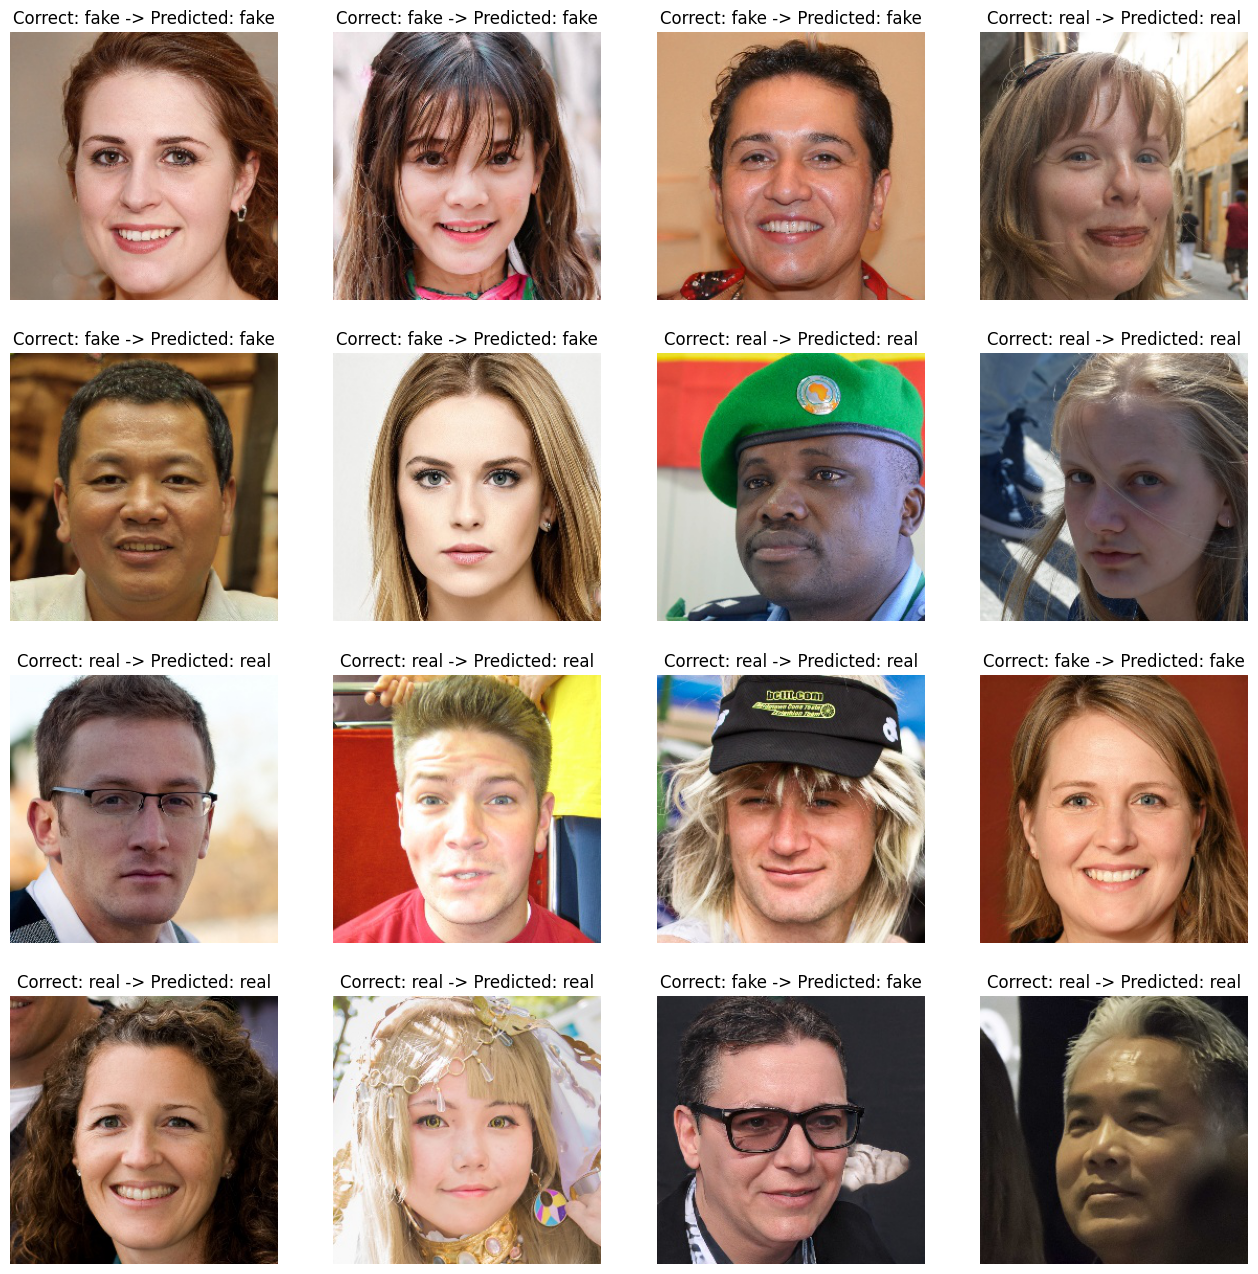

In [68]:
indices = [random.randint(0, len(subsample)) for i in range(16)]
model = model.to(device)  # Move the model to the appropriate device
predictions_view(indices)

###**3.4.1.2. Visualização dos resultados**

Função para analisar os resultados coletando qual o melhor experimento de cada modelo.

In [108]:
import pandas as pd

# Ler o arquivo CSV
data = pd.read_csv('metricas.csv')

def encontrar_melhor_experimento(modelo, metrica):
    # Filtrar os dados para o modelo especificado
    dados_modelo = data[data['Modelo'] == modelo]

    # Calcular a média da métrica nos testes para cada experimento
    media_metrica = dados_modelo.groupby('Experimento')[f'Test {metrica}'].mean()

    # Encontrar o experimento com o melhor desempenho
    melhor_experimento = media_metrica.idxmax()

    # Retornar o número do melhor experimento e o valor da métrica correspondente
    return melhor_experimento, media_metrica.loc[melhor_experimento]

# Exemplo de uso para encontrar o melhor experimento (ACC ou F1 nos testes) para o modelo ViT
modelo_vit = 'vit'
metrica_escolhida = 'F1'  # Pode ser 'ACC' ou 'F1'

melhor_experimento_vit, melhor_metrica_vit = encontrar_melhor_experimento(modelo_vit, metrica_escolhida)
print("="*90)
print(f"\nMelhor experimento para o modelo ViT:\t\t Experimento {melhor_experimento_vit}, {metrica_escolhida}: {round(melhor_metrica_vit* 100, 2)}%\n")
print("="*90)

modelo_conv = 'convnext'
metrica_escolhida = 'F1'  # Pode ser 'ACC' ou 'F1'

melhor_experimento_conv, melhor_metrica_conv = encontrar_melhor_experimento(modelo_conv, metrica_escolhida)
print(f"\nMelhor experimento para o modelo ConvNeXt:\t Experimento {melhor_experimento_conv}, {metrica_escolhida}: {round(melhor_metrica_conv * 100, 4)}%\n")
print("="*90)



Melhor experimento para o modelo ViT:		 Experimento 2, F1: 94.37%


Melhor experimento para o modelo ConvNeXt:	 Experimento 6, F1: 99.88%



Plotagem das curvas de aprendizagem e média de resultados.

ConvNeXt


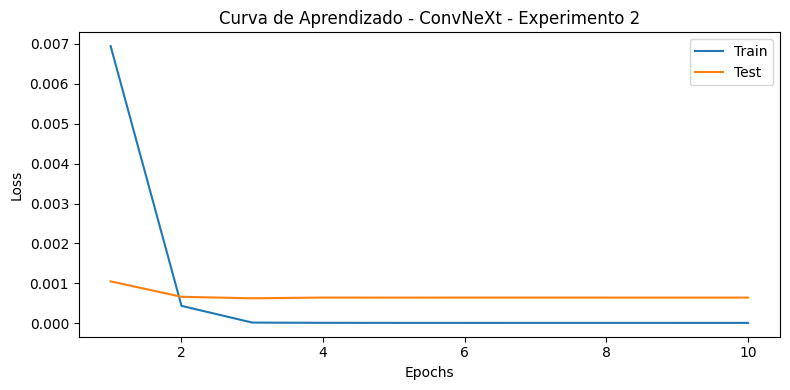

ConvNeXt


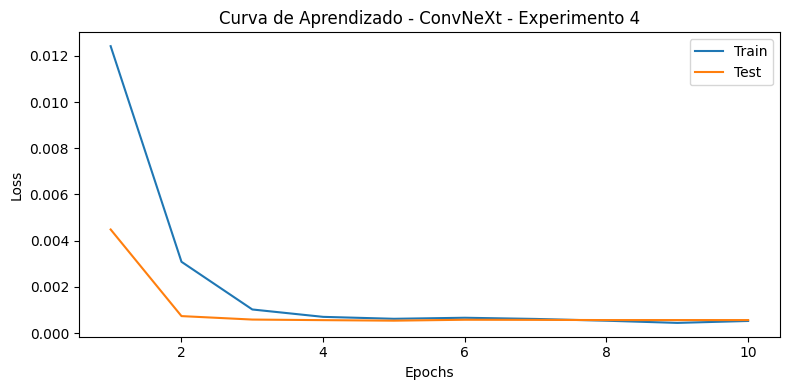

ConvNeXt


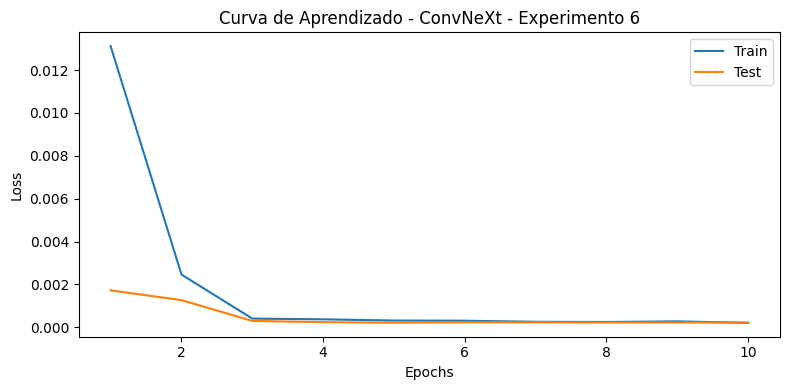

ConvNeXt


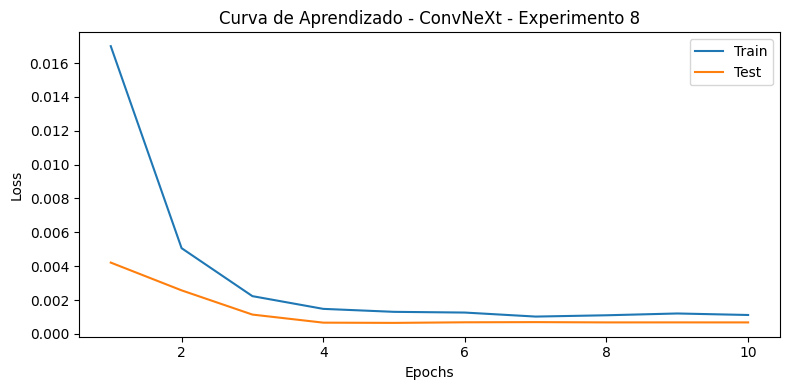

ViT


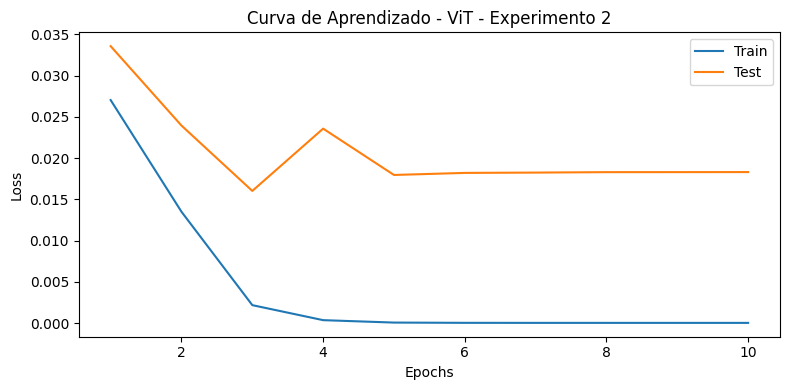

ViT


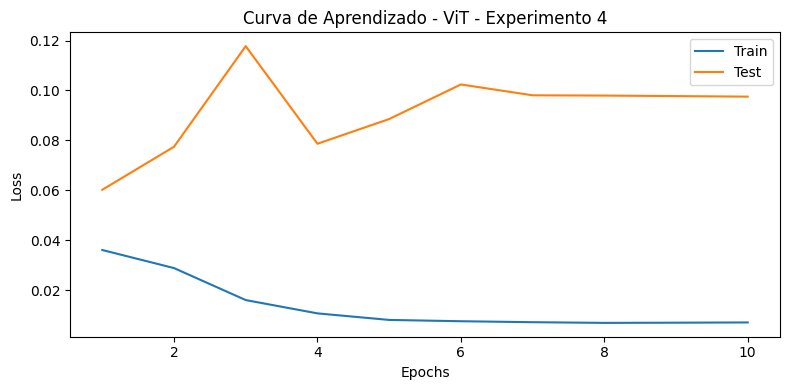

ViT


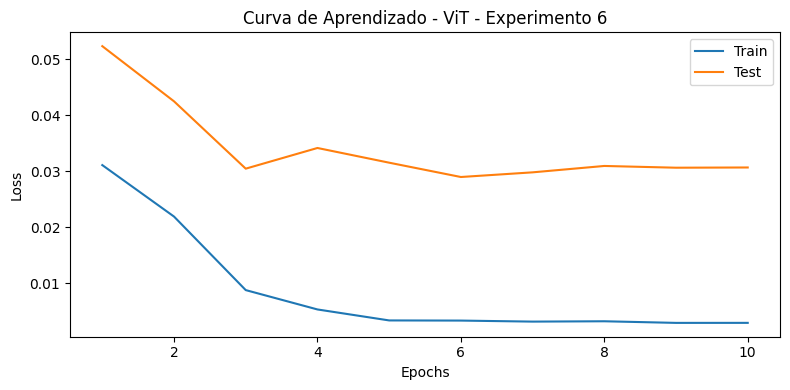

ViT


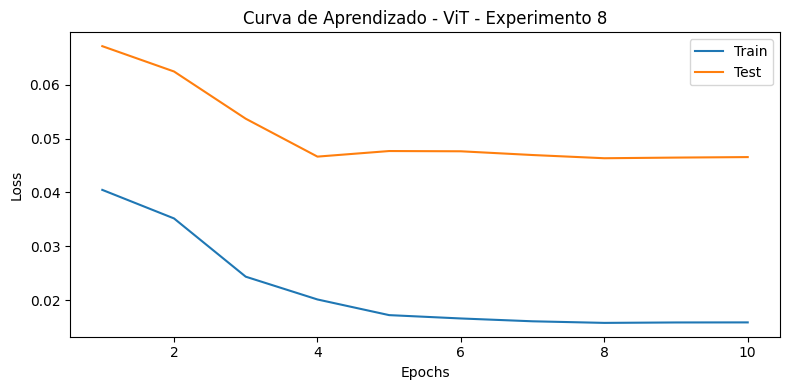

In [39]:
modelos=data['Modelo'].unique()
for modelo in modelos:
    experimentos = data[(data['Modelo'] == modelo) & (data['Experimento'] % 2 == 0)]['Experimento'].unique()

    for experimento in experimentos:
        dados_experimento = data[(data['Modelo'] == modelo) & (data['Experimento'] == experimento) & (data['Experimento'] % 2 == 0)]
        epochs = dados_experimento['Epoch']
        train_loss = dados_experimento['Train Loss']
        test_loss = dados_experimento['Test Loss']

        plt.figure(figsize=(8, 4))
        plt.plot(epochs, train_loss, label='Train')
        plt.plot(epochs, test_loss, label='Test')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')

        if modelo == 'convnext':
          modelo = 'ConvNeXt'
        elif modelo == 'vit':
          modelo = 'ViT'
        print(modelo)
        plt.title(f'Curva de Aprendizado - {modelo} - Experimento {experimento}')
        if modelo == 'ConvNeXt':
          modelo = 'convnext'
        elif modelo == 'ViT':
          modelo = 'vit'
        plt.legend()
        plt.tight_layout()
        plt.show()

ConvNeXt


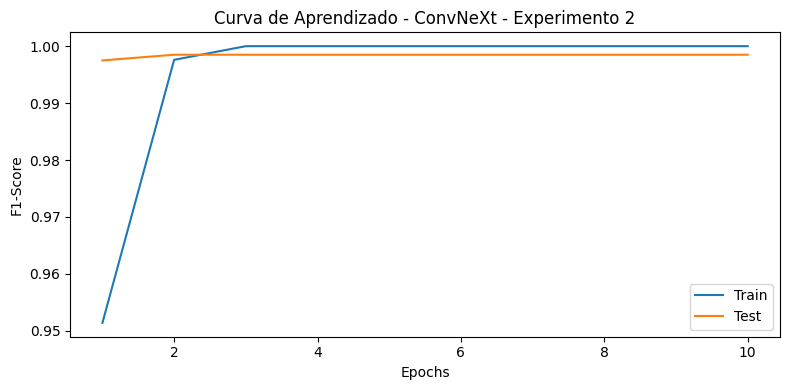

ConvNeXt


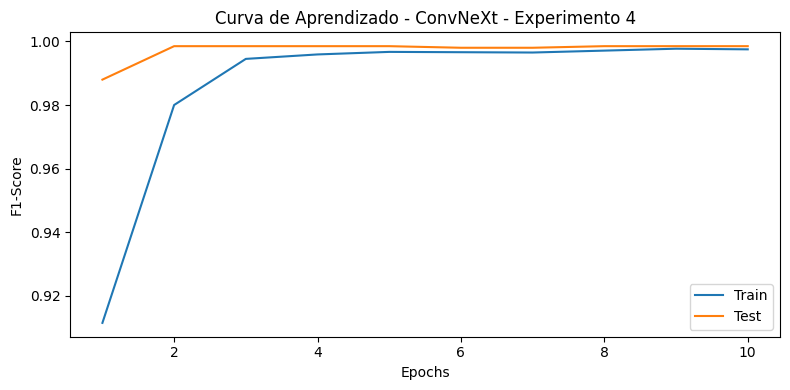

ConvNeXt


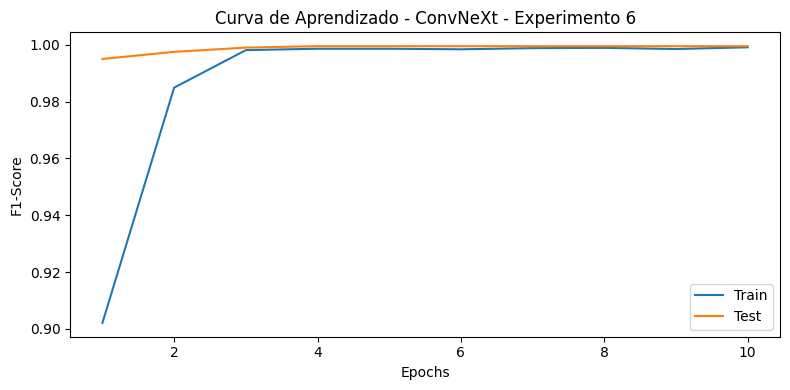

ConvNeXt


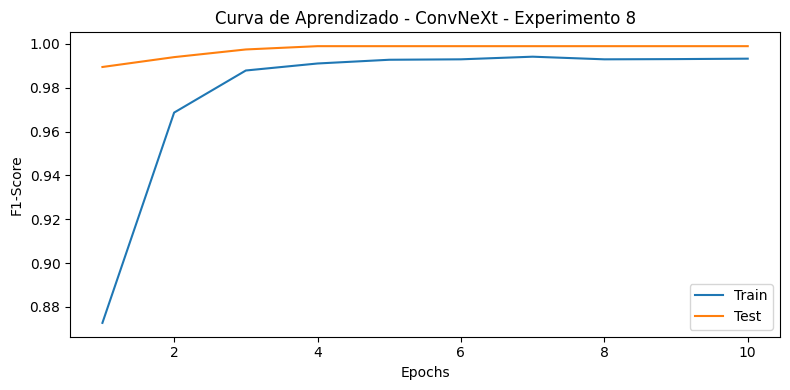

ViT


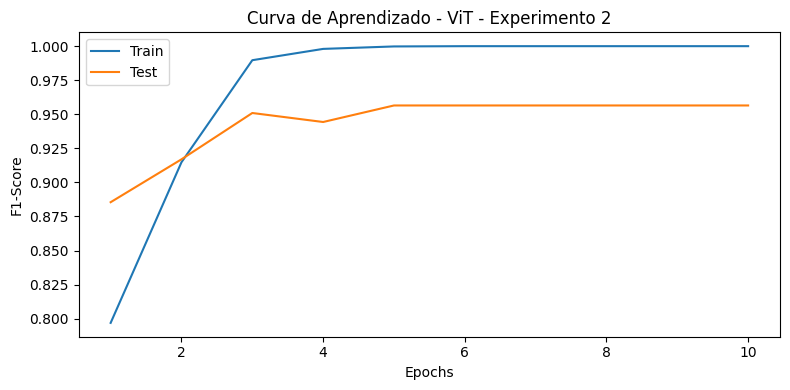

ViT


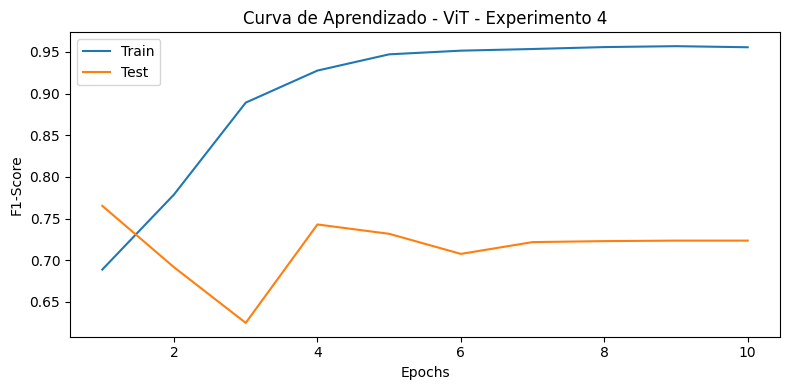

ViT


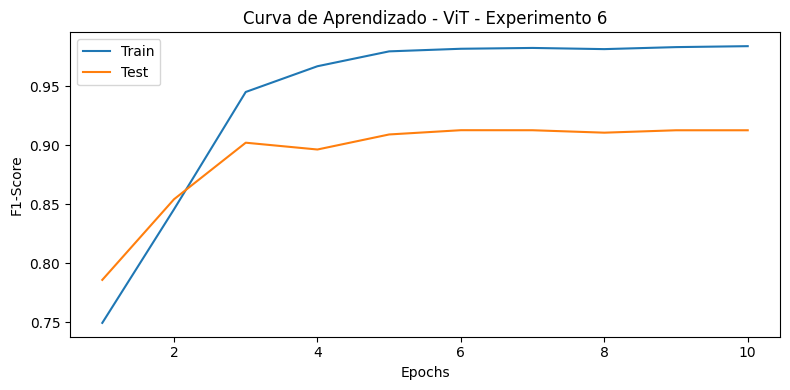

ViT


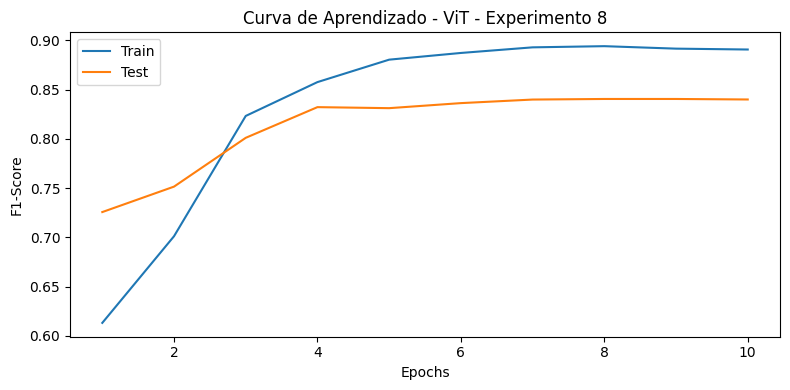

In [13]:
for modelo in modelos:
    experimentos = data[(data['Modelo'] == modelo) & (data['Experimento'] % 2 == 0)]['Experimento'].unique()

    for experimento in experimentos:
        dados_experimento = data[(data['Modelo'] == modelo) & (data['Experimento'] == experimento) & (data['Experimento'] % 2 == 0)]
        epochs = dados_experimento['Epoch']
        train_loss = dados_experimento['Train F1']
        test_loss = dados_experimento['Test F1']

        plt.figure(figsize=(8, 4))
        plt.plot(epochs, train_loss, label='Train')
        plt.plot(epochs, test_loss, label='Test')
        plt.xlabel('Epochs')
        plt.ylabel('F1-Score')

        if modelo == 'convnext':
          modelo = 'ConvNeXt'
        elif modelo == 'vit':
          modelo = 'ViT'
        print(modelo)
        plt.title(f'Curva de Aprendizado - {modelo} - Experimento {experimento}')
        if modelo == 'ConvNeXt':
          modelo = 'convnext'
        elif modelo == 'ViT':
          modelo = 'vit'
        plt.legend()
        plt.tight_layout()
        plt.show()

<ipython-input-20-0578d759b8c9>:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cores_convnext = plt.cm.get_cmap('tab10')(np.linspace(0, 1, num_experimentos_convnext))


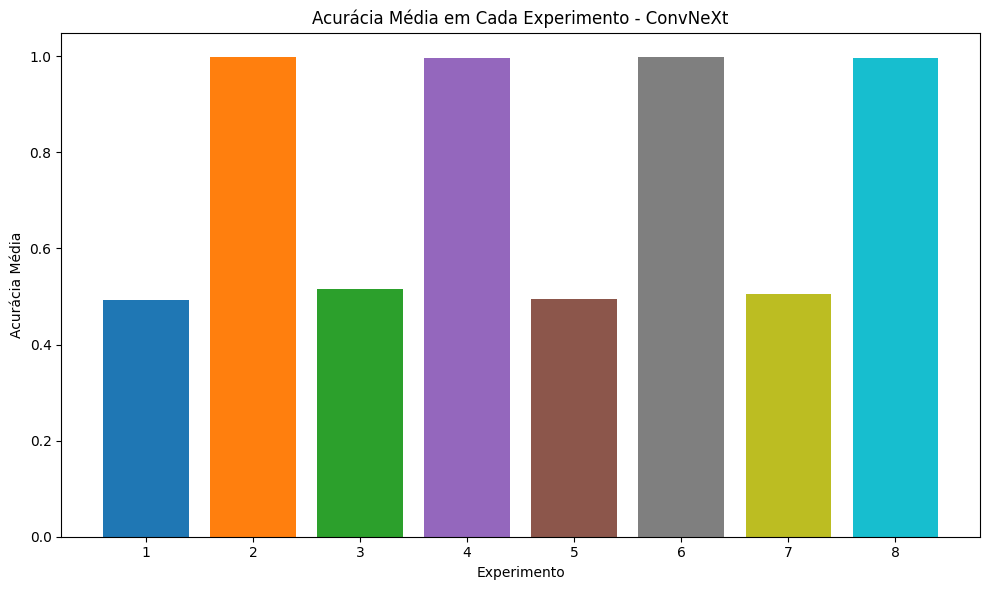

<ipython-input-20-0578d759b8c9>:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cores_vit = plt.cm.get_cmap('tab10')(np.linspace(0, 1, num_experimentos_vit))


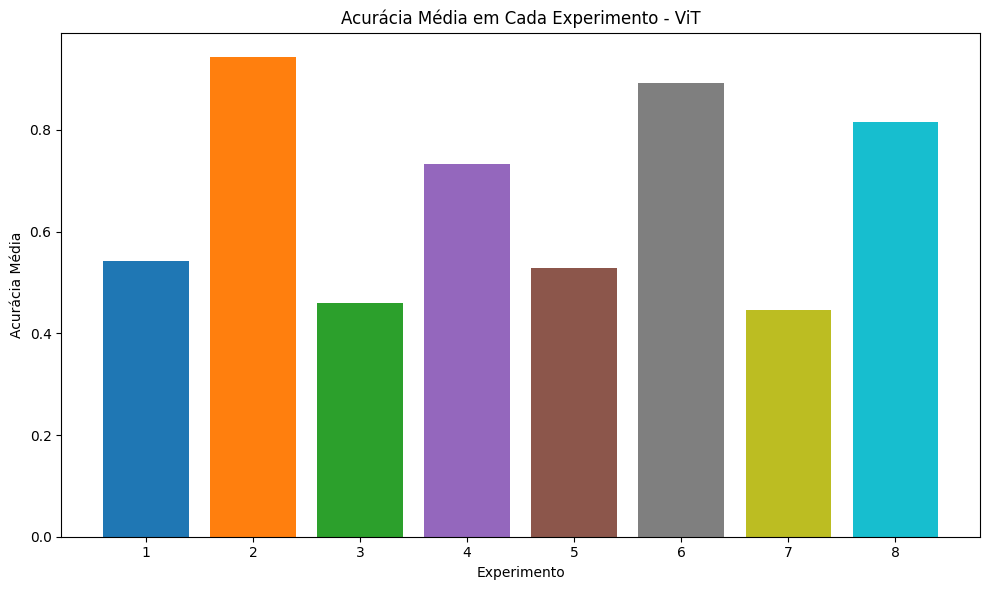

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Filtrar os dados para o modelo "convnext"
dados_convnext = data[data['Modelo'] == 'convnext']

# Calcular a acurácia média em cada experimento para o modelo "convnext"
media_acuracia_convnext = dados_convnext.groupby('Experimento')['Test ACC'].mean()

# Definir o número de experimentos
num_experimentos_convnext = len(media_acuracia_convnext)

# Gerar cores personalizadas para cada experimento
cores_convnext = plt.cm.get_cmap('tab10')(np.linspace(0, 1, num_experimentos_convnext))

# Plotar gráfico de barras para o modelo "convnext" com cores diferentes para cada experimento
plt.figure(figsize=(10, 6))
plt.bar(media_acuracia_convnext.index, media_acuracia_convnext, color=cores_convnext)
plt.xlabel('Experimento')
plt.ylabel('Acurácia Média')
plt.title('Acurácia Média em Cada Experimento - ConvNeXt')
plt.xticks(media_acuracia_convnext.index)
plt.tight_layout()
plt.show()

# Filtrar os dados para o modelo "vit"
dados_vit = data[data['Modelo'] == 'vit']

# Calcular a acurácia média em cada experimento para o modelo "vit"
media_acuracia_vit = dados_vit.groupby('Experimento')['Test ACC'].mean()

# Definir o número de experimentos
num_experimentos_vit = len(media_acuracia_vit)

# Gerar cores personalizadas para cada experimento
cores_vit = plt.cm.get_cmap('tab10')(np.linspace(0, 1, num_experimentos_vit))

# Plotar gráfico de barras para o modelo "vit" com cores diferentes para cada experimento
plt.figure(figsize=(10, 6))
plt.bar(media_acuracia_vit.index, media_acuracia_vit, color=cores_vit)
plt.xlabel('Experimento')
plt.ylabel('Acurácia Média')
plt.title('Acurácia Média em Cada Experimento - ViT')
plt.xticks(media_acuracia_vit.index)
plt.tight_layout()
plt.show()
